In [27]:
import csv
import h5py
import itertools
import requests
import numpy as np
import scipy.integrate
import illustris_python as il
import matplotlib.pyplot as plt
from scipy.optimize import fminbound
from hoki.csp.eventrate import CSPEventRate
from hoki.constants import BPASS_EVENT_TYPES, BPASS_METALLICITIES

In [2]:
# helper function to get subhalo data
def get(path, params=None):
    r = requests.get(path, params=params, headers={"api-key":"ac0fbfe1251d6f93c582c5490527df5d"})
    r.raise_for_status()  # raise exception if the request does not succeed (does not get HTTP code 200)
    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string
    return r

In [3]:
@np.vectorize
def calc_LB(z, omega0, omega1, hubble):
    '''
    Calculates the lookback time according to Hobbs.

    Parameters:
    z : float
        The redshift at which you want to calculate the lookback
    omega0 : float
        The Matter density parameter (0.3111 Planck 2018)
    omega1 : float
        The dark energy density parameter (0.6889 Planck 2018)
    hubble : float
        The hubble parameters (0.6766 Planck 2018)
    '''
    def func(x):
        E = np.sqrt(omega0*(1+x)**3 + omega1)
        return 1/((1+x)*E)
    # can be simplified by already doing the extra coefficient calculations
    t_hubble = (1/(100*hubble))*3.0856776*10**19
    return t_hubble *scipy.integrate.quad(func, 0, z)[0]/(60*60*24*365.2388526)

In [4]:
data = h5py.File(f"./data.h5", "r")
SFH = data['SFH']['TNG']
er_csp = CSPEventRate("./BPASS data/", imf="imf135_300", binary=True)

In [5]:
event_types = ["Ia", "IIP", "II", "Ib", "Ic", "LGRB", "PISNe"]

In [6]:
# TNG cosmology
h = 0.6774
omega_M = 0.3089
omega_L = 0.6911

lookback_time91 = calc_LB(SFH.attrs['redshift'][8:], omega_M, omega_L, h)
lookback_time67 = calc_LB(SFH.attrs['redshift'][32:], omega_M, omega_L, h)
lookback_time50 = calc_LB(SFH.attrs['redshift'][49:], omega_M, omega_L, h)
lookback_time17 = calc_LB(SFH.attrs['redshift'][82:], omega_M, omega_L, h)

In [7]:
# making event rate data for mass2

SFR2 = []
with open('./zData/91_mass2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR2.append(row)
SFR2_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR2)):
    SFR2_Z[subhalo] = [float(num) for num in SFR2[subhalo]]
for index in range(len(SFR2_Z)):
    SFR2_Z[index] = np.array(SFR2_Z[index][::-1])
SFR2_Z = np.array([SFR2_Z])
out2_91, edges2_91 = er_csp.grid_over_time(SFR2_Z, lookback_time91, event_types , 92, return_time_edges=True)
out2_91 = out2_91[0]
edges2_91 = edges2_91[:-1]

SFR2 = []
with open('./zData/67_mass2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR2.append(row)
SFR2_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR2)):
    SFR2_Z[subhalo] = [float(num) for num in SFR2[subhalo]]
for index in range(len(SFR2_Z)):
    SFR2_Z[index] = np.array(SFR2_Z[index][::-1])
SFR2_Z = np.array([SFR2_Z])
out2_67, edges2_67 = er_csp.grid_over_time(SFR2_Z, lookback_time67, event_types , 68, return_time_edges=True)
out2_67 = out2_67[0]
edges2_67 = edges2_67[:-1]

SFR2 = []
with open('./zData/50_mass2.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR2.append(row)
SFR2_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR2)):
    SFR2_Z[subhalo] = [float(num) for num in SFR2[subhalo]]
for index in range(len(SFR2_Z)):
    SFR2_Z[index] = np.array(SFR2_Z[index][::-1])
SFR2_Z = np.array([SFR2_Z])
out2_50, edges2_50 = er_csp.grid_over_time(SFR2_Z, lookback_time50, event_types , 51, return_time_edges=True)
out2_50 = out2_50[0]
edges2_50 = edges2_50[:-1]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/tmp/ipykernel_1736/2229036314.py:53: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axis[2,0].set_yscale('log')
/tmp/ipykernel_1736/2229036314.py:63: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axis[2,1].set_yscale('log')


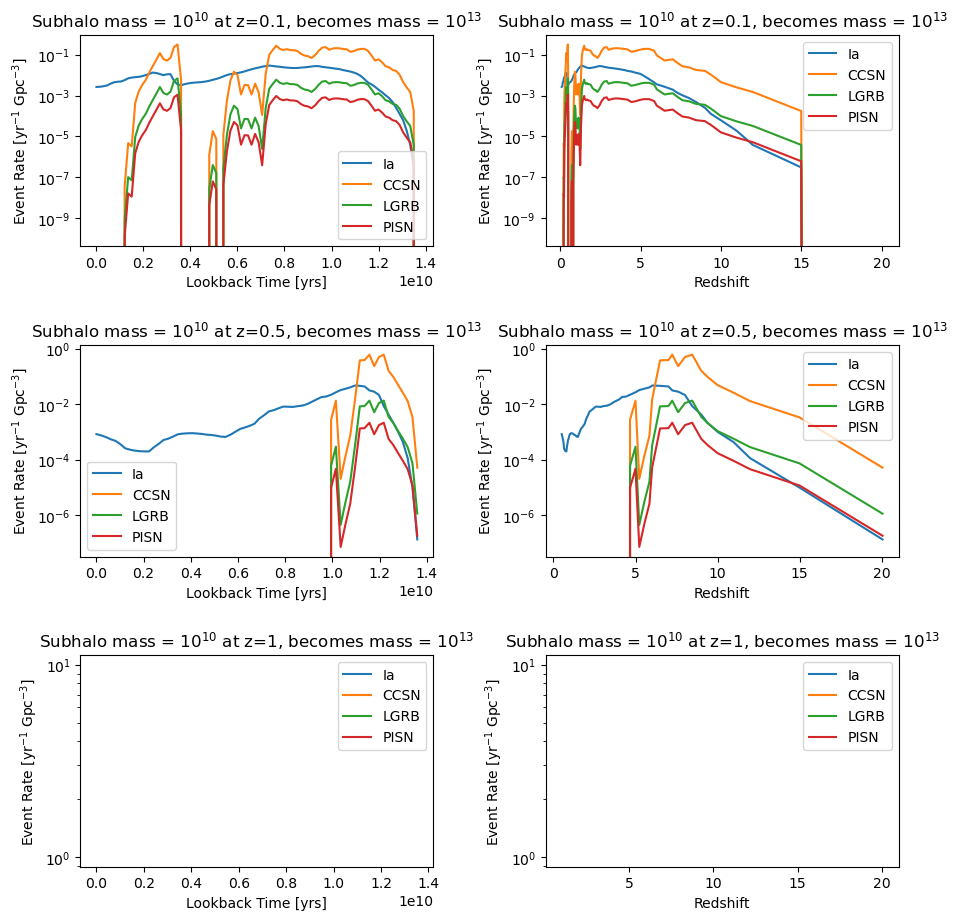

In [8]:
# plotting data for mass2 group

figure, axis = plt.subplots(3, 2, figsize=(10, 10))
figure.tight_layout(pad=5.0)

# z=91
axis[0,0].plot(edges2_91, out2_91[:,0][0], label='Ia')
axis[0,0].plot(edges2_91, out2_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,0].plot(edges2_91, out2_91[:,5][0], label='LGRB')
axis[0,0].plot(edges2_91, out2_91[:,6][0], label='PISN')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Subhalo mass = 10$^{10}$ at z=0.1, becomes mass = 10$^{13}$")
axis[0,0].legend()

axis[0,1].plot(SFH.attrs['redshift'][8:], out2_91[:,0][0], label='Ia')
axis[0,1].plot(SFH.attrs['redshift'][8:], out2_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,1].plot(SFH.attrs['redshift'][8:], out2_91[:,5][0], label='LGRB')
axis[0,1].plot(SFH.attrs['redshift'][8:], out2_91[:,6][0], label='PISN')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Subhalo mass = 10$^{10}$ at z=0.1, becomes mass = 10$^{13}$")
axis[0,1].legend()

# z=67
axis[1,0].plot(edges2_67, out2_67[:,0][0], label='Ia')
axis[1,0].plot(edges2_67, out2_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,0].plot(edges2_67, out2_67[:,5][0], label='LGRB')
axis[1,0].plot(edges2_67, out2_67[:,6][0], label='PISN')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Subhalo mass = 10$^{10}$ at z=0.5, becomes mass = 10$^{13}$")
axis[1,0].legend()

axis[1,1].plot(SFH.attrs['redshift'][32:], out2_67[:,0][0], label='Ia')
axis[1,1].plot(SFH.attrs['redshift'][32:], out2_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,1].plot(SFH.attrs['redshift'][32:], out2_67[:,5][0], label='LGRB')
axis[1,1].plot(SFH.attrs['redshift'][32:], out2_67[:,6][0], label='PISN')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Subhalo mass = 10$^{10}$ at z=0.5, becomes mass = 10$^{13}$")
axis[1,1].legend()

# z=50
axis[2,0].plot(edges2_50, out2_50[:,0][0], label='Ia')
axis[2,0].plot(edges2_50, out2_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,0].plot(edges2_50, out2_50[:,5][0], label='LGRB')
axis[2,0].plot(edges2_50, out2_50[:,6][0], label='PISN')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Subhalo mass = 10$^{10}$ at z=1, becomes mass = 10$^{13}$")
axis[2,0].legend()

axis[2,1].plot(SFH.attrs['redshift'][49:], out2_50[:,0][0], label='Ia')
axis[2,1].plot(SFH.attrs['redshift'][49:], out2_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,1].plot(SFH.attrs['redshift'][49:], out2_50[:,5][0], label='LGRB')
axis[2,1].plot(SFH.attrs['redshift'][49:], out2_50[:,6][0], label='PISN')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Subhalo mass = 10$^{10}$ at z=1, becomes mass = 10$^{13}$")
axis[2,1].legend()

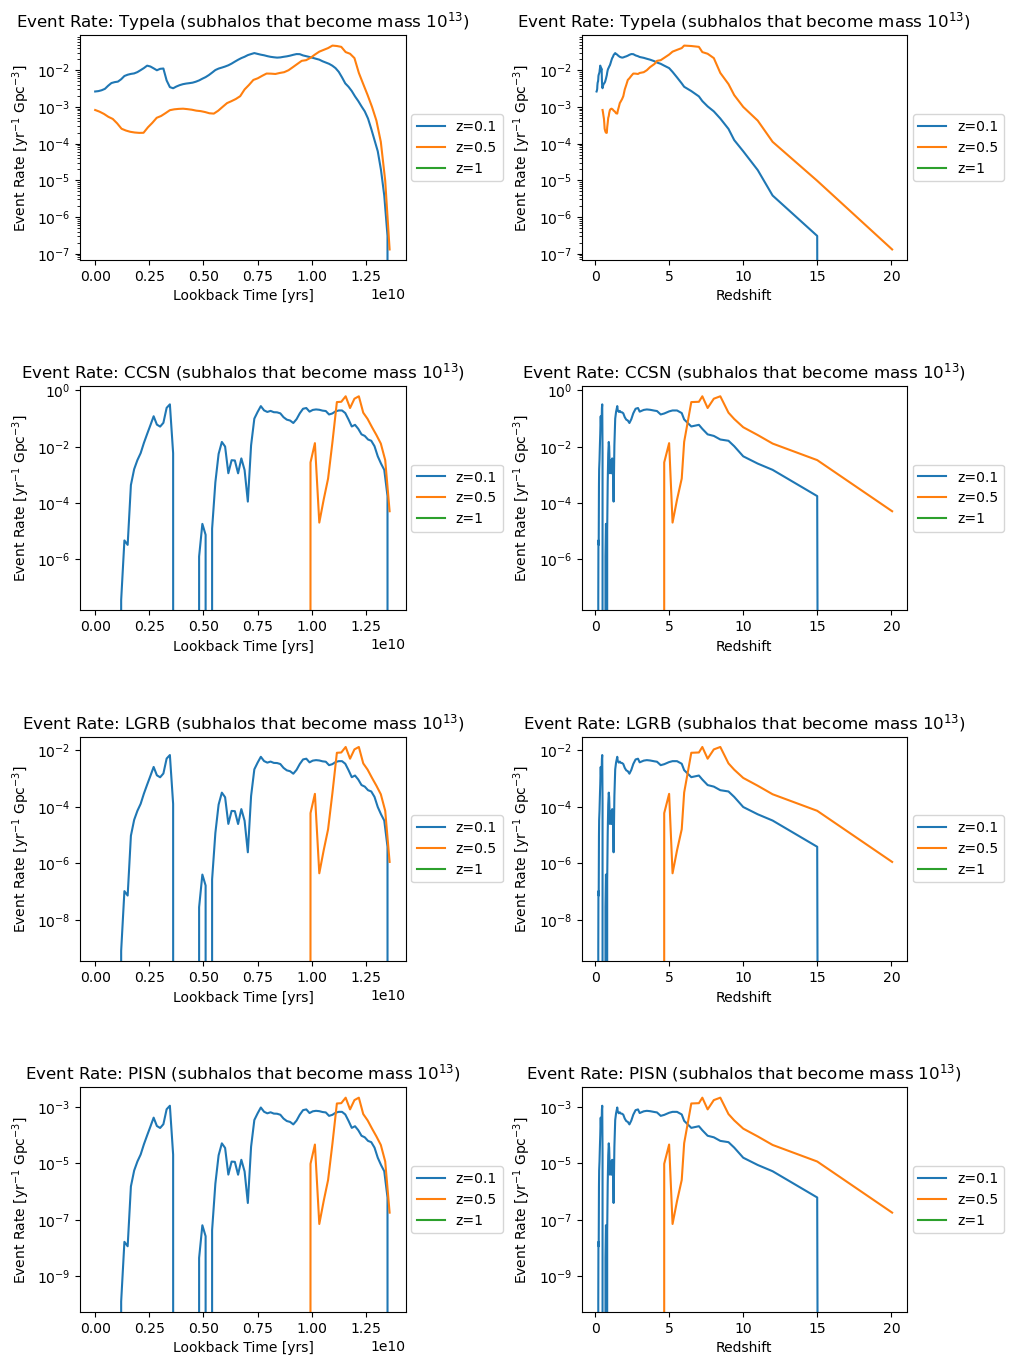

In [9]:
# comparing between redshifts for mass2

figure, axis = plt.subplots(4, 2, figsize=(11, 15))
figure.tight_layout(pad=7.0)

# typeIa
axis[0,0].plot(edges2_91, out2_91[:,0][0], label='z=0.1')
axis[0,0].plot(edges2_67, out2_67[:,0][0], label='z=0.5')
axis[0,0].plot(edges2_50, out2_50[:,0][0], label='z=1')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: TypeIa (subhalos that become mass 10$^{13}$)")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'][8:], out2_91[:,0][0], label='z=0.1')
axis[0,1].plot(SFH.attrs['redshift'][32:], out2_67[:,0][0], label='z=0.5')
axis[0,1].plot(SFH.attrs['redshift'][49:], out2_50[:,0][0], label='z=1')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: TypeIa (subhalos that become mass 10$^{13}$)")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# CCSN
axis[1,0].plot(edges2_91, out2_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,0].plot(edges2_67, out2_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,0].plot(edges2_50, out2_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: CCSN (subhalos that become mass 10$^{13}$)")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'][8:], out2_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,1].plot(SFH.attrs['redshift'][32:], out2_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,1].plot(SFH.attrs['redshift'][49:], out2_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: CCSN (subhalos that become mass 10$^{13}$)")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# LGRB
axis[2,0].plot(edges2_91, out2_91[:,5][0], label='z=0.1')
axis[2,0].plot(edges2_67, out2_67[:,5][0], label='z=0.5')
axis[2,0].plot(edges2_50, out2_50[:,5][0], label='z=1')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: LGRB (subhalos that become mass 10$^{13}$)")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'][8:], out2_91[:,5][0], label='z=0.1')
axis[2,1].plot(SFH.attrs['redshift'][32:], out2_67[:,5][0], label='z=0.5')
axis[2,1].plot(SFH.attrs['redshift'][49:], out2_50[:,5][0], label='z=1')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: LGRB (subhalos that become mass 10$^{13}$)")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# PISN
axis[3,0].plot(edges2_91, out2_91[:,6][0], label='z=0.1')
axis[3,0].plot(edges2_67, out2_67[:,6][0], label='z=0.5')
axis[3,0].plot(edges2_50, out2_50[:,6][0], label='z=1')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: PISN (subhalos that become mass 10$^{13}$)")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'][8:], out2_91[:,6][0], label='z=0.1')
axis[3,1].plot(SFH.attrs['redshift'][32:], out2_67[:,6][0], label='z=0.5')
axis[3,1].plot(SFH.attrs['redshift'][49:], out2_50[:,6][0], label='z=1')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: PISN (subhalos that become mass 10$^{13}$)")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

In [10]:
# making event rate data for mass3

SFR3 = []
with open('./zData/91_mass3.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR3.append(row)
SFR3_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR3)):
    SFR3_Z[subhalo] = [float(num) for num in SFR3[subhalo]]
for index in range(len(SFR3_Z)):
    SFR3_Z[index] = np.array(SFR3_Z[index][::-1])
SFR3_Z = np.array([SFR3_Z])
out3_91, edges3_91 = er_csp.grid_over_time(SFR3_Z, lookback_time91, event_types , 92, return_time_edges=True)
out3_91 = out3_91[0]
edges3_91 = edges3_91[:-1]

SFR3 = []
with open('./zData/67_mass3.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR3.append(row)
SFR3_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR3)):
    SFR3_Z[subhalo] = [float(num) for num in SFR3[subhalo]]
for index in range(len(SFR3_Z)):
    SFR3_Z[index] = np.array(SFR3_Z[index][::-1])
SFR3_Z = np.array([SFR3_Z])
out3_67, edges3_67 = er_csp.grid_over_time(SFR3_Z, lookback_time67, event_types , 68, return_time_edges=True)
out3_67 = out3_67[0]
edges3_67 = edges3_67[:-1]

SFR3 = []
with open('./zData/50_mass3.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR3.append(row)
SFR3_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR3)):
    SFR3_Z[subhalo] = [float(num) for num in SFR3[subhalo]]
for index in range(len(SFR3_Z)):
    SFR3_Z[index] = np.array(SFR3_Z[index][::-1])
SFR3_Z = np.array([SFR3_Z])
out3_50, edges3_50 = er_csp.grid_over_time(SFR3_Z, lookback_time50, event_types , 51, return_time_edges=True)
out3_50 = out3_50[0]
edges3_50 = edges3_50[:-1]

SFR3 = []
with open('./zData/17_mass3.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR3.append(row)
SFR3_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR3)):
    SFR3_Z[subhalo] = [float(num) for num in SFR3[subhalo]]
for index in range(len(SFR3_Z)):
    SFR3_Z[index] = np.array(SFR3_Z[index][::-1])
SFR3_Z = np.array([SFR3_Z])
out3_17, edges3_17 = er_csp.grid_over_time(SFR3_Z, lookback_time17, event_types , 18, return_time_edges=True)
out3_17 = out3_17[0]
edges3_17 = edges3_17[:-1]

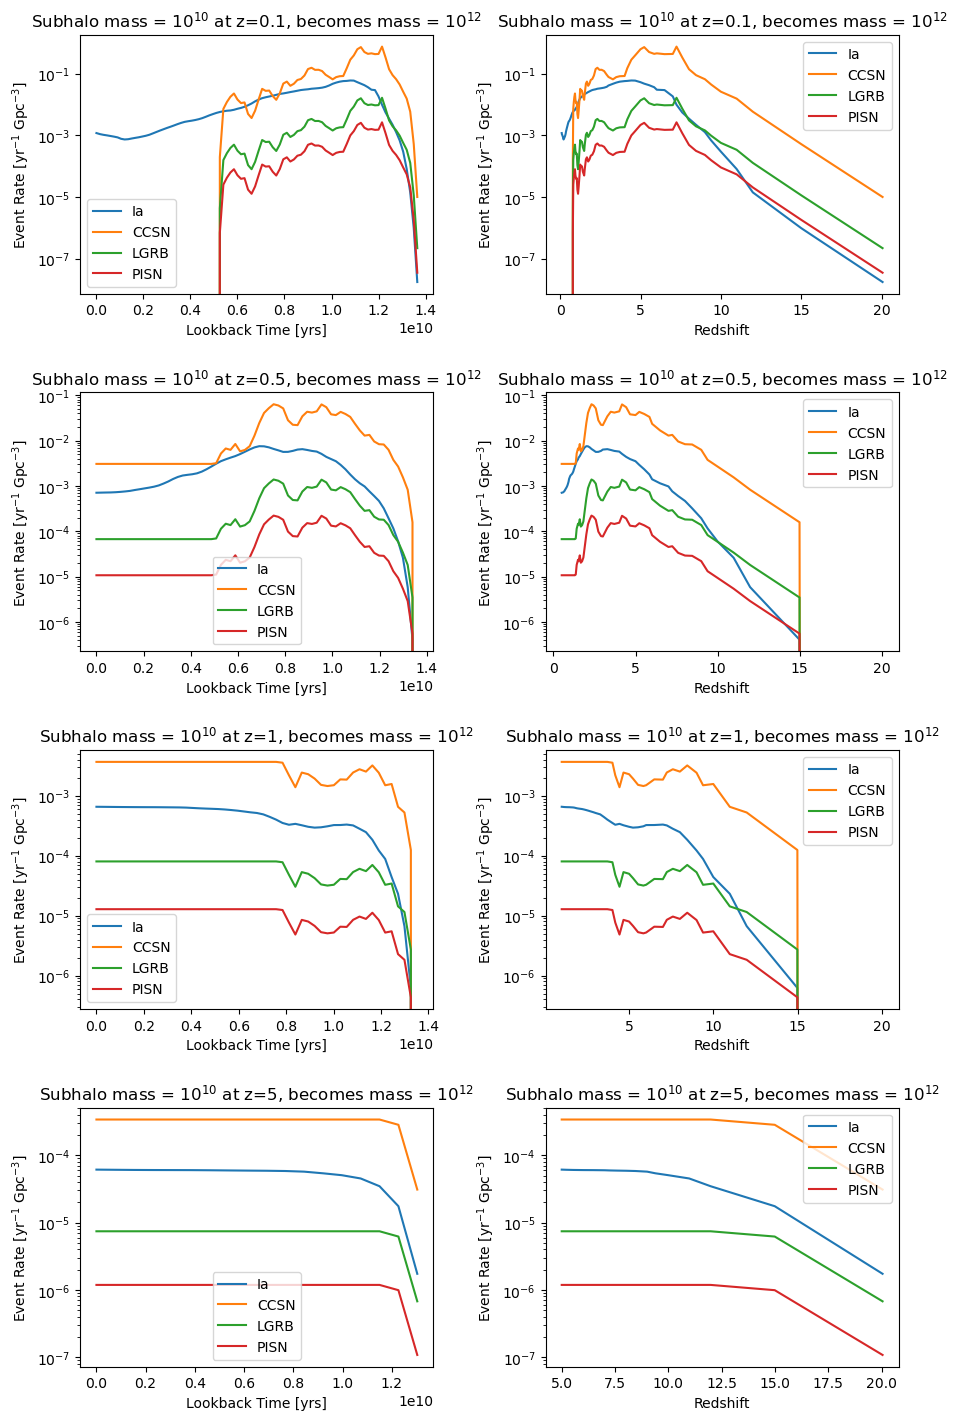

In [11]:
# plotting data for mass3 group

figure, axis = plt.subplots(4, 2, figsize=(10, 15))
figure.tight_layout(pad=5.0)

# z=91
axis[0,0].plot(edges3_91, out3_91[:,0][0], label='Ia')
axis[0,0].plot(edges3_91, out3_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,0].plot(edges3_91, out3_91[:,5][0], label='LGRB')
axis[0,0].plot(edges3_91, out3_91[:,6][0], label='PISN')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Subhalo mass = 10$^{10}$ at z=0.1, becomes mass = 10$^{12}$")
axis[0,0].legend()

axis[0,1].plot(SFH.attrs['redshift'][8:], out3_91[:,0][0], label='Ia')
axis[0,1].plot(SFH.attrs['redshift'][8:], out3_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,1].plot(SFH.attrs['redshift'][8:], out3_91[:,5][0], label='LGRB')
axis[0,1].plot(SFH.attrs['redshift'][8:], out3_91[:,6][0], label='PISN')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Subhalo mass = 10$^{10}$ at z=0.1, becomes mass = 10$^{12}$")
axis[0,1].legend()

# z=67
axis[1,0].plot(edges3_67, out3_67[:,0][0], label='Ia')
axis[1,0].plot(edges3_67, out3_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,0].plot(edges3_67, out3_67[:,5][0], label='LGRB')
axis[1,0].plot(edges3_67, out3_67[:,6][0], label='PISN')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Subhalo mass = 10$^{10}$ at z=0.5, becomes mass = 10$^{12}$")
axis[1,0].legend()

axis[1,1].plot(SFH.attrs['redshift'][32:], out3_67[:,0][0], label='Ia')
axis[1,1].plot(SFH.attrs['redshift'][32:], out3_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,1].plot(SFH.attrs['redshift'][32:], out3_67[:,5][0], label='LGRB')
axis[1,1].plot(SFH.attrs['redshift'][32:], out3_67[:,6][0], label='PISN')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Subhalo mass = 10$^{10}$ at z=0.5, becomes mass = 10$^{12}$")
axis[1,1].legend()

# z=50
axis[2,0].plot(edges3_50, out3_50[:,0][0], label='Ia')
axis[2,0].plot(edges3_50, out3_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,0].plot(edges3_50, out3_50[:,5][0], label='LGRB')
axis[2,0].plot(edges3_50, out3_50[:,6][0], label='PISN')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Subhalo mass = 10$^{10}$ at z=1, becomes mass = 10$^{12}$")
axis[2,0].legend()

axis[2,1].plot(SFH.attrs['redshift'][49:], out3_50[:,0][0], label='Ia')
axis[2,1].plot(SFH.attrs['redshift'][49:], out3_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,1].plot(SFH.attrs['redshift'][49:], out3_50[:,5][0], label='LGRB')
axis[2,1].plot(SFH.attrs['redshift'][49:], out3_50[:,6][0], label='PISN')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Subhalo mass = 10$^{10}$ at z=1, becomes mass = 10$^{12}$")
axis[2,1].legend()

# z=17
axis[3,0].plot(edges3_17, out3_17[:,0][0], label='Ia')
axis[3,0].plot(edges3_17, out3_17[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,0].plot(edges3_17, out3_17[:,5][0], label='LGRB')
axis[3,0].plot(edges3_17, out3_17[:,6][0], label='PISN')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Subhalo mass = 10$^{10}$ at z=5, becomes mass = 10$^{12}$")
axis[3,0].legend()

axis[3,1].plot(SFH.attrs['redshift'][82:], out3_17[:,0][0], label='Ia')
axis[3,1].plot(SFH.attrs['redshift'][82:], out3_17[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,1].plot(SFH.attrs['redshift'][82:], out3_17[:,5][0], label='LGRB')
axis[3,1].plot(SFH.attrs['redshift'][82:], out3_17[:,6][0], label='PISN')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Subhalo mass = 10$^{10}$ at z=5, becomes mass = 10$^{12}$")
axis[3,1].legend()

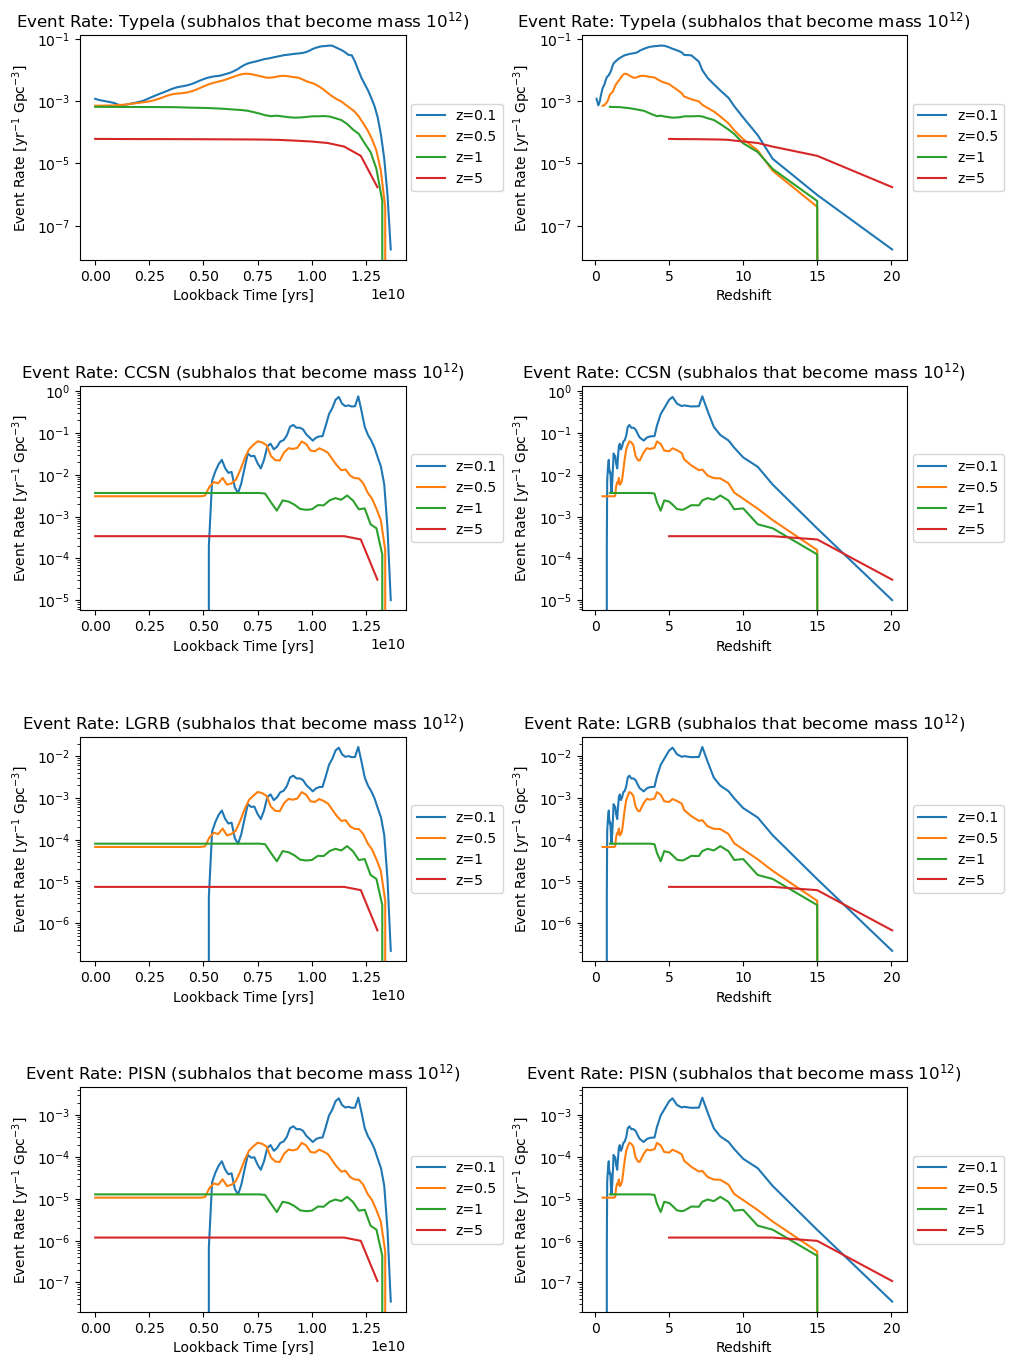

In [12]:
# comparing between redshifts for mass3

figure, axis = plt.subplots(4, 2, figsize=(11, 15))
figure.tight_layout(pad=7.0)

# typeIa
axis[0,0].plot(edges3_91, out3_91[:,0][0], label='z=0.1')
axis[0,0].plot(edges3_67, out3_67[:,0][0], label='z=0.5')
axis[0,0].plot(edges3_50, out3_50[:,0][0], label='z=1')
axis[0,0].plot(edges3_17, out3_17[:,0][0], label='z=5')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: TypeIa (subhalos that become mass 10$^{12}$)")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'][8:], out3_91[:,0][0], label='z=0.1')
axis[0,1].plot(SFH.attrs['redshift'][32:], out3_67[:,0][0], label='z=0.5')
axis[0,1].plot(SFH.attrs['redshift'][49:], out3_50[:,0][0], label='z=1')
axis[0,1].plot(SFH.attrs['redshift'][82:], out3_17[:,0][0], label='z=5')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: TypeIa (subhalos that become mass 10$^{12}$)")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# CCSN
axis[1,0].plot(edges3_91, out3_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,0].plot(edges3_67, out3_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,0].plot(edges3_50, out3_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,0].plot(edges3_17, out3_17[:,1:5][0].sum(axis=0), label='z=5')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: CCSN (subhalos that become mass 10$^{12}$)")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'][8:], out3_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,1].plot(SFH.attrs['redshift'][32:], out3_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,1].plot(SFH.attrs['redshift'][49:], out3_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,1].plot(SFH.attrs['redshift'][82:], out3_17[:,1:5][0].sum(axis=0), label='z=5')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: CCSN (subhalos that become mass 10$^{12}$)")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# LGRB
axis[2,0].plot(edges3_91, out3_91[:,5][0], label='z=0.1')
axis[2,0].plot(edges3_67, out3_67[:,5][0], label='z=0.5')
axis[2,0].plot(edges3_50, out3_50[:,5][0], label='z=1')
axis[2,0].plot(edges3_17, out3_17[:,5][0], label='z=5')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: LGRB (subhalos that become mass 10$^{12}$)")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'][8:], out3_91[:,5][0], label='z=0.1')
axis[2,1].plot(SFH.attrs['redshift'][32:], out3_67[:,5][0], label='z=0.5')
axis[2,1].plot(SFH.attrs['redshift'][49:], out3_50[:,5][0], label='z=1')
axis[2,1].plot(SFH.attrs['redshift'][82:], out3_17[:,5][0], label='z=5')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: LGRB (subhalos that become mass 10$^{12}$)")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# PISN
axis[3,0].plot(edges3_91, out3_91[:,6][0], label='z=0.1')
axis[3,0].plot(edges3_67, out3_67[:,6][0], label='z=0.5')
axis[3,0].plot(edges3_50, out3_50[:,6][0], label='z=1')
axis[3,0].plot(edges3_17, out3_17[:,6][0], label='z=5')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: PISN (subhalos that become mass 10$^{12}$)")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'][8:], out3_91[:,6][0], label='z=0.1')
axis[3,1].plot(SFH.attrs['redshift'][32:], out3_67[:,6][0], label='z=0.5')
axis[3,1].plot(SFH.attrs['redshift'][49:], out3_50[:,6][0], label='z=1')
axis[3,1].plot(SFH.attrs['redshift'][82:], out3_17[:,6][0], label='z=5')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: PISN (subhalos that become mass 10$^{12}$)")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

In [13]:
# making event rate data for mass4

SFR4 = []
with open('./zData/91_mass4.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR4.append(row)
SFR4_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR4)):
    SFR4_Z[subhalo] = [float(num) for num in SFR4[subhalo]]
for index in range(len(SFR4_Z)):
    SFR4_Z[index] = np.array(SFR4_Z[index][::-1])
SFR4_Z = np.array([SFR4_Z])
out4_91, edges4_91 = er_csp.grid_over_time(SFR4_Z, lookback_time91, event_types , 92, return_time_edges=True)
out4_91 = out4_91[0]
edges4_91 = edges4_91[:-1]

SFR4 = []
with open('./zData/67_mass4.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR4.append(row)
SFR4_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR4)):
    SFR4_Z[subhalo] = [float(num) for num in SFR4[subhalo]]
for index in range(len(SFR4_Z)):
    SFR4_Z[index] = np.array(SFR4_Z[index][::-1])
SFR4_Z = np.array([SFR4_Z])
out4_67, edges4_67 = er_csp.grid_over_time(SFR4_Z, lookback_time67, event_types , 68, return_time_edges=True)
out4_67 = out4_67[0]
edges4_67 = edges4_67[:-1]

SFR4 = []
with open('./zData/50_mass4.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR4.append(row)
SFR4_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR4)):
    SFR4_Z[subhalo] = [float(num) for num in SFR4[subhalo]]
for index in range(len(SFR4_Z)):
    SFR4_Z[index] = np.array(SFR4_Z[index][::-1])
SFR4_Z = np.array([SFR4_Z])
out4_50, edges4_50 = er_csp.grid_over_time(SFR4_Z, lookback_time50, event_types , 51, return_time_edges=True)
out4_50 = out4_50[0]
edges4_50 = edges4_50[:-1]

SFR4 = []
with open('./zData/17_mass4.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR4.append(row)
SFR4_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR4)):
    SFR4_Z[subhalo] = [float(num) for num in SFR4[subhalo]]
for index in range(len(SFR4_Z)):
    SFR4_Z[index] = np.array(SFR4_Z[index][::-1])
SFR4_Z = np.array([SFR4_Z])
out4_17, edges4_17 = er_csp.grid_over_time(SFR4_Z, lookback_time17, event_types , 18, return_time_edges=True)
out4_17 = out4_17[0]
edges4_17 = edges4_17[:-1]

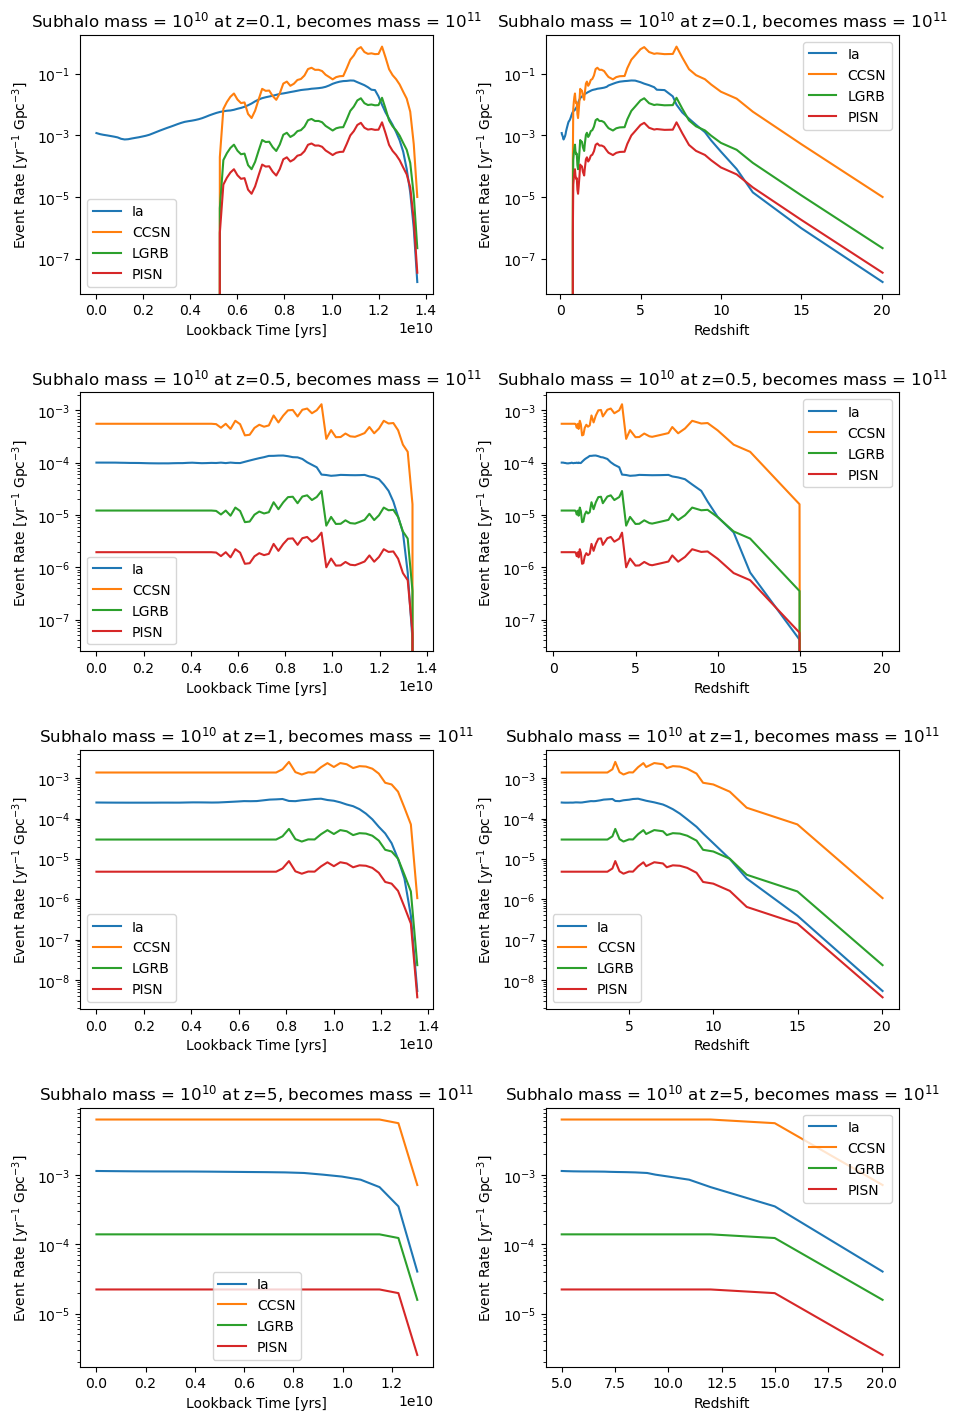

In [14]:
# plotting data for mass4 group

figure, axis = plt.subplots(4, 2, figsize=(10, 15))
figure.tight_layout(pad=5.0)

# z=91
axis[0,0].plot(edges4_91, out4_91[:,0][0], label='Ia')
axis[0,0].plot(edges4_91, out4_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,0].plot(edges4_91, out4_91[:,5][0], label='LGRB')
axis[0,0].plot(edges4_91, out4_91[:,6][0], label='PISN')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Subhalo mass = 10$^{10}$ at z=0.1, becomes mass = 10$^{11}$")
axis[0,0].legend()

axis[0,1].plot(SFH.attrs['redshift'][8:], out4_91[:,0][0], label='Ia')
axis[0,1].plot(SFH.attrs['redshift'][8:], out4_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,1].plot(SFH.attrs['redshift'][8:], out4_91[:,5][0], label='LGRB')
axis[0,1].plot(SFH.attrs['redshift'][8:], out4_91[:,6][0], label='PISN')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Subhalo mass = 10$^{10}$ at z=0.1, becomes mass = 10$^{11}$")
axis[0,1].legend()

# z=67
axis[1,0].plot(edges4_67, out4_67[:,0][0], label='Ia')
axis[1,0].plot(edges4_67, out4_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,0].plot(edges4_67, out4_67[:,5][0], label='LGRB')
axis[1,0].plot(edges4_67, out4_67[:,6][0], label='PISN')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Subhalo mass = 10$^{10}$ at z=0.5, becomes mass = 10$^{11}$")
axis[1,0].legend()

axis[1,1].plot(SFH.attrs['redshift'][32:], out4_67[:,0][0], label='Ia')
axis[1,1].plot(SFH.attrs['redshift'][32:], out4_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,1].plot(SFH.attrs['redshift'][32:], out4_67[:,5][0], label='LGRB')
axis[1,1].plot(SFH.attrs['redshift'][32:], out4_67[:,6][0], label='PISN')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Subhalo mass = 10$^{10}$ at z=0.5, becomes mass = 10$^{11}$")
axis[1,1].legend()

# z=50
axis[2,0].plot(edges4_50, out4_50[:,0][0], label='Ia')
axis[2,0].plot(edges4_50, out4_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,0].plot(edges4_50, out4_50[:,5][0], label='LGRB')
axis[2,0].plot(edges4_50, out4_50[:,6][0], label='PISN')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Subhalo mass = 10$^{10}$ at z=1, becomes mass = 10$^{11}$")
axis[2,0].legend()

axis[2,1].plot(SFH.attrs['redshift'][49:], out4_50[:,0][0], label='Ia')
axis[2,1].plot(SFH.attrs['redshift'][49:], out4_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,1].plot(SFH.attrs['redshift'][49:], out4_50[:,5][0], label='LGRB')
axis[2,1].plot(SFH.attrs['redshift'][49:], out4_50[:,6][0], label='PISN')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Subhalo mass = 10$^{10}$ at z=1, becomes mass = 10$^{11}$")
axis[2,1].legend()

# z=17
axis[3,0].plot(edges4_17, out4_17[:,0][0], label='Ia')
axis[3,0].plot(edges4_17, out4_17[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,0].plot(edges4_17, out4_17[:,5][0], label='LGRB')
axis[3,0].plot(edges4_17, out4_17[:,6][0], label='PISN')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Subhalo mass = 10$^{10}$ at z=5, becomes mass = 10$^{11}$")
axis[3,0].legend()

axis[3,1].plot(SFH.attrs['redshift'][82:], out4_17[:,0][0], label='Ia')
axis[3,1].plot(SFH.attrs['redshift'][82:], out4_17[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,1].plot(SFH.attrs['redshift'][82:], out4_17[:,5][0], label='LGRB')
axis[3,1].plot(SFH.attrs['redshift'][82:], out4_17[:,6][0], label='PISN')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Subhalo mass = 10$^{10}$ at z=5, becomes mass = 10$^{11}$")
axis[3,1].legend()

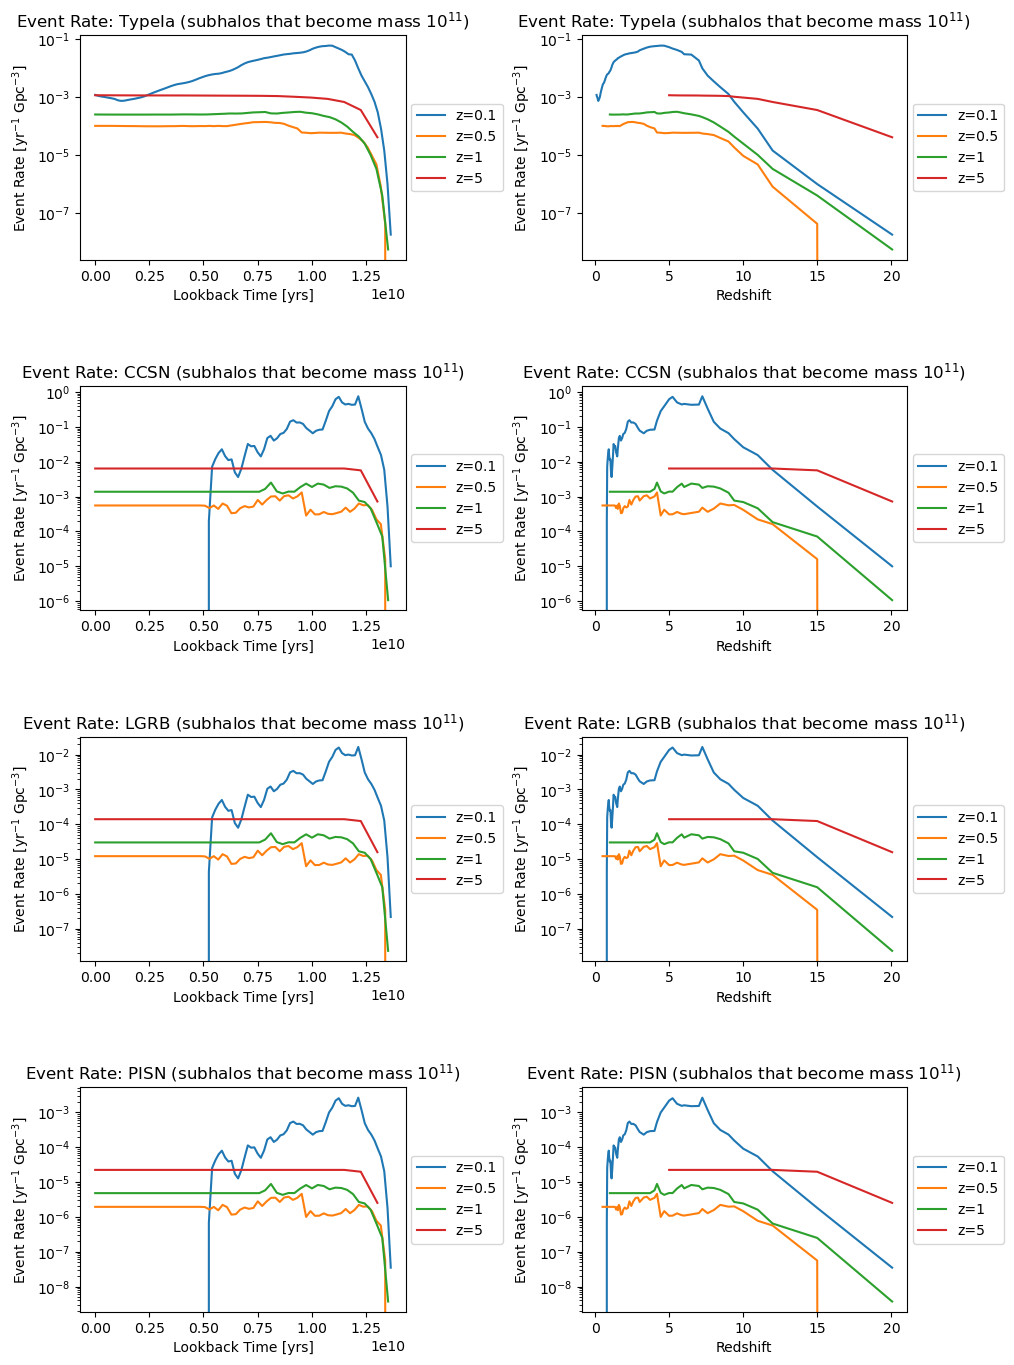

In [15]:
# comparing between redshifts for mass4

figure, axis = plt.subplots(4, 2, figsize=(11, 15))
figure.tight_layout(pad=7.0)

# typeIa
axis[0,0].plot(edges4_91, out4_91[:,0][0], label='z=0.1')
axis[0,0].plot(edges4_67, out4_67[:,0][0], label='z=0.5')
axis[0,0].plot(edges4_50, out4_50[:,0][0], label='z=1')
axis[0,0].plot(edges4_17, out4_17[:,0][0], label='z=5')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: TypeIa (subhalos that become mass 10$^{11}$)")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'][8:], out4_91[:,0][0], label='z=0.1')
axis[0,1].plot(SFH.attrs['redshift'][32:], out4_67[:,0][0], label='z=0.5')
axis[0,1].plot(SFH.attrs['redshift'][49:], out4_50[:,0][0], label='z=1')
axis[0,1].plot(SFH.attrs['redshift'][82:], out4_17[:,0][0], label='z=5')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: TypeIa (subhalos that become mass 10$^{11}$)")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# CCSN
axis[1,0].plot(edges4_91, out4_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,0].plot(edges4_67, out4_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,0].plot(edges4_50, out4_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,0].plot(edges4_17, out4_17[:,1:5][0].sum(axis=0), label='z=5')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: CCSN (subhalos that become mass 10$^{11}$)")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'][8:], out4_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,1].plot(SFH.attrs['redshift'][32:], out4_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,1].plot(SFH.attrs['redshift'][49:], out4_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,1].plot(SFH.attrs['redshift'][82:], out4_17[:,1:5][0].sum(axis=0), label='z=5')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: CCSN (subhalos that become mass 10$^{11}$)")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# LGRB
axis[2,0].plot(edges4_91, out4_91[:,5][0], label='z=0.1')
axis[2,0].plot(edges4_67, out4_67[:,5][0], label='z=0.5')
axis[2,0].plot(edges4_50, out4_50[:,5][0], label='z=1')
axis[2,0].plot(edges4_17, out4_17[:,5][0], label='z=5')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: LGRB (subhalos that become mass 10$^{11}$)")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'][8:], out4_91[:,5][0], label='z=0.1')
axis[2,1].plot(SFH.attrs['redshift'][32:], out4_67[:,5][0], label='z=0.5')
axis[2,1].plot(SFH.attrs['redshift'][49:], out4_50[:,5][0], label='z=1')
axis[2,1].plot(SFH.attrs['redshift'][82:], out4_17[:,5][0], label='z=5')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: LGRB (subhalos that become mass 10$^{11}$)")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# PISN
axis[3,0].plot(edges4_91, out4_91[:,6][0], label='z=0.1')
axis[3,0].plot(edges4_67, out4_67[:,6][0], label='z=0.5')
axis[3,0].plot(edges4_50, out4_50[:,6][0], label='z=1')
axis[3,0].plot(edges4_17, out4_17[:,6][0], label='z=5')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: PISN (subhalos that become mass 10$^{11}$)")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'][8:], out4_91[:,6][0], label='z=0.1')
axis[3,1].plot(SFH.attrs['redshift'][32:], out4_67[:,6][0], label='z=0.5')
axis[3,1].plot(SFH.attrs['redshift'][49:], out4_50[:,6][0], label='z=1')
axis[3,1].plot(SFH.attrs['redshift'][82:], out4_17[:,6][0], label='z=5')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: PISN (subhalos that become mass 10$^{11}$)")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

In [16]:
# making event rate data for mass5

SFR5 = []
with open('./zData/91_mass5.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR5.append(row)
SFR5_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR5)):
    SFR5_Z[subhalo] = [float(num) for num in SFR5[subhalo]]
for index in range(len(SFR5_Z)):
    SFR5_Z[index] = np.array(SFR5_Z[index][::-1])
SFR5_Z = np.array([SFR5_Z])
out5_91, edges5_91 = er_csp.grid_over_time(SFR5_Z, lookback_time91, event_types , 92, return_time_edges=True)
out5_91 = out5_91[0]
edges5_91 = edges5_91[:-1]

SFR5 = []
with open('./zData/67_mass5.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR5.append(row)
SFR5_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR5)):
    SFR5_Z[subhalo] = [float(num) for num in SFR5[subhalo]]
for index in range(len(SFR5_Z)):
    SFR5_Z[index] = np.array(SFR5_Z[index][::-1])
SFR5_Z = np.array([SFR5_Z])
out5_67, edges5_67 = er_csp.grid_over_time(SFR5_Z, lookback_time67, event_types , 68, return_time_edges=True)
out5_67 = out5_67[0]
edges5_67 = edges5_67[:-1]

SFR5 = []
with open('./zData/50_mass5.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR5.append(row)
SFR5_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR5)):
    SFR5_Z[subhalo] = [float(num) for num in SFR5[subhalo]]
for index in range(len(SFR5_Z)):
    SFR5_Z[index] = np.array(SFR5_Z[index][::-1])
SFR5_Z = np.array([SFR5_Z])
out5_50, edges5_50 = er_csp.grid_over_time(SFR5_Z, lookback_time50, event_types , 51, return_time_edges=True)
out5_50 = out5_50[0]
edges5_50 = edges5_50[:-1]

SFR5 = []
with open('./zData/17_mass5.txt', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        SFR5.append(row)
SFR5_Z = [[], [], [], [], [], [], [], [], [], [], [], [], []]
for subhalo in range(len(SFR5)):
    SFR5_Z[subhalo] = [float(num) for num in SFR5[subhalo]]
for index in range(len(SFR5_Z)):
    SFR5_Z[index] = np.array(SFR5_Z[index][::-1])
SFR5_Z = np.array([SFR5_Z])
out5_17, edges5_17 = er_csp.grid_over_time(SFR5_Z, lookback_time17, event_types , 18, return_time_edges=True)
out5_17 = out5_17[0]
edges5_17 = edges5_17[:-1]

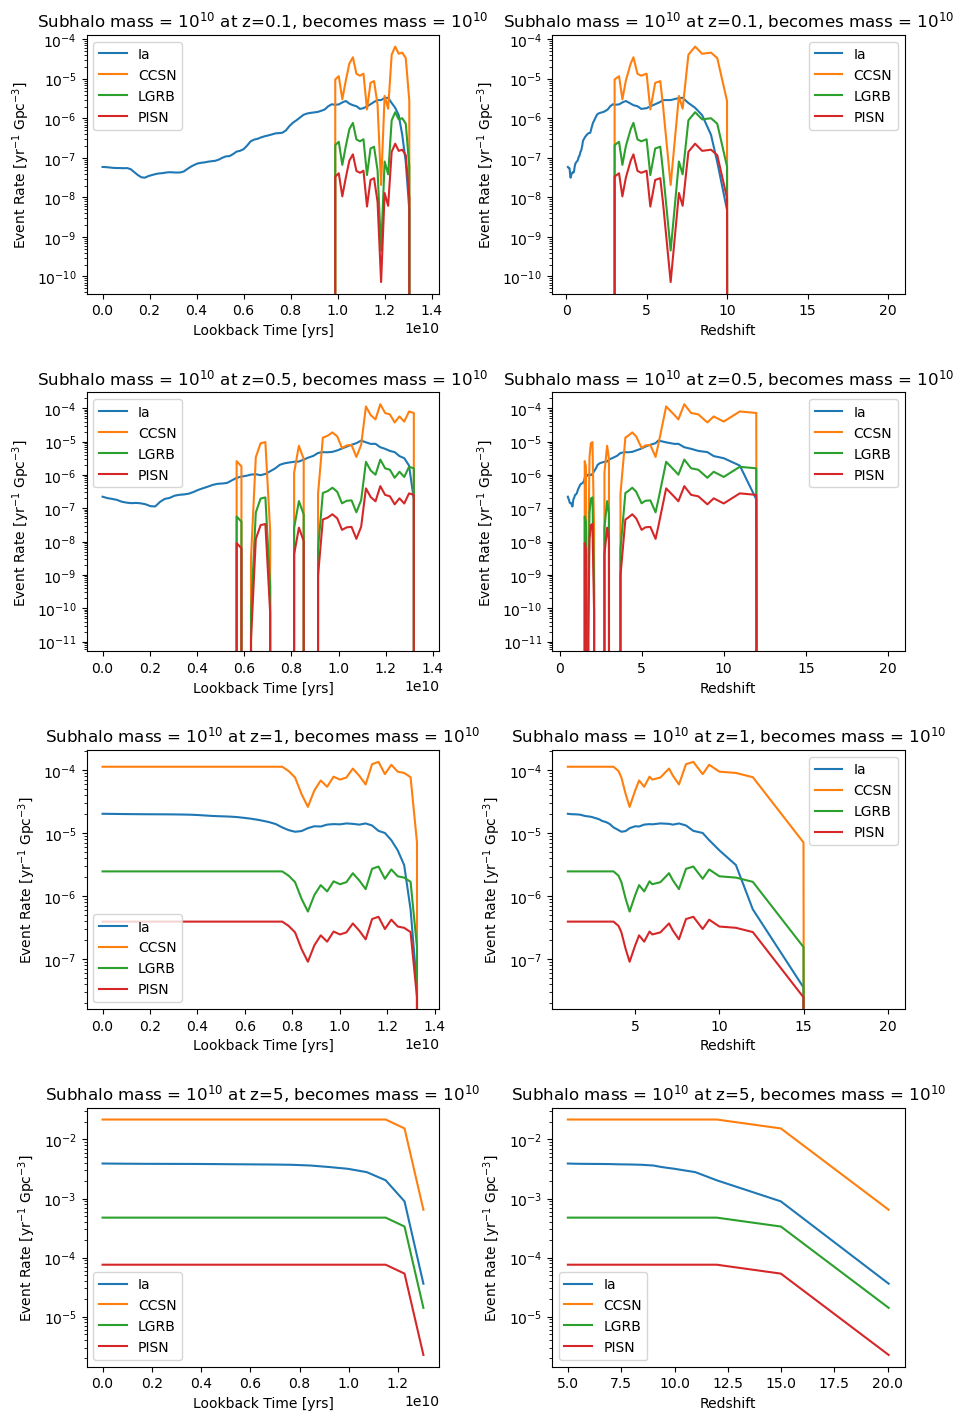

In [17]:
# plotting data for mass5 group

figure, axis = plt.subplots(4, 2, figsize=(10, 15))
figure.tight_layout(pad=5.0)

# z=91
axis[0,0].plot(edges5_91, out5_91[:,0][0], label='Ia')
axis[0,0].plot(edges5_91, out5_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,0].plot(edges5_91, out5_91[:,5][0], label='LGRB')
axis[0,0].plot(edges5_91, out5_91[:,6][0], label='PISN')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Subhalo mass = 10$^{10}$ at z=0.1, becomes mass = 10$^{10}$")
axis[0,0].legend()

axis[0,1].plot(SFH.attrs['redshift'][8:], out5_91[:,0][0], label='Ia')
axis[0,1].plot(SFH.attrs['redshift'][8:], out5_91[:,1:5][0].sum(axis=0), label='CCSN')
axis[0,1].plot(SFH.attrs['redshift'][8:], out5_91[:,5][0], label='LGRB')
axis[0,1].plot(SFH.attrs['redshift'][8:], out5_91[:,6][0], label='PISN')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Subhalo mass = 10$^{10}$ at z=0.1, becomes mass = 10$^{10}$")
axis[0,1].legend()

# z=67
axis[1,0].plot(edges5_67, out5_67[:,0][0], label='Ia')
axis[1,0].plot(edges5_67, out5_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,0].plot(edges5_67, out5_67[:,5][0], label='LGRB')
axis[1,0].plot(edges5_67, out5_67[:,6][0], label='PISN')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Subhalo mass = 10$^{10}$ at z=0.5, becomes mass = 10$^{10}$")
axis[1,0].legend()

axis[1,1].plot(SFH.attrs['redshift'][32:], out5_67[:,0][0], label='Ia')
axis[1,1].plot(SFH.attrs['redshift'][32:], out5_67[:,1:5][0].sum(axis=0), label='CCSN')
axis[1,1].plot(SFH.attrs['redshift'][32:], out5_67[:,5][0], label='LGRB')
axis[1,1].plot(SFH.attrs['redshift'][32:], out5_67[:,6][0], label='PISN')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Subhalo mass = 10$^{10}$ at z=0.5, becomes mass = 10$^{10}$")
axis[1,1].legend()

# z=50
axis[2,0].plot(edges5_50, out5_50[:,0][0], label='Ia')
axis[2,0].plot(edges5_50, out5_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,0].plot(edges5_50, out5_50[:,5][0], label='LGRB')
axis[2,0].plot(edges5_50, out5_50[:,6][0], label='PISN')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Subhalo mass = 10$^{10}$ at z=1, becomes mass = 10$^{10}$")
axis[2,0].legend()

axis[2,1].plot(SFH.attrs['redshift'][49:], out5_50[:,0][0], label='Ia')
axis[2,1].plot(SFH.attrs['redshift'][49:], out5_50[:,1:5][0].sum(axis=0), label='CCSN')
axis[2,1].plot(SFH.attrs['redshift'][49:], out5_50[:,5][0], label='LGRB')
axis[2,1].plot(SFH.attrs['redshift'][49:], out5_50[:,6][0], label='PISN')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Subhalo mass = 10$^{10}$ at z=1, becomes mass = 10$^{10}$")
axis[2,1].legend()

# z=17
axis[3,0].plot(edges5_17, out5_17[:,0][0], label='Ia')
axis[3,0].plot(edges5_17, out5_17[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,0].plot(edges5_17, out5_17[:,5][0], label='LGRB')
axis[3,0].plot(edges5_17, out5_17[:,6][0], label='PISN')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Subhalo mass = 10$^{10}$ at z=5, becomes mass = 10$^{10}$")
axis[3,0].legend()

axis[3,1].plot(SFH.attrs['redshift'][82:], out5_17[:,0][0], label='Ia')
axis[3,1].plot(SFH.attrs['redshift'][82:], out5_17[:,1:5][0].sum(axis=0), label='CCSN')
axis[3,1].plot(SFH.attrs['redshift'][82:], out5_17[:,5][0], label='LGRB')
axis[3,1].plot(SFH.attrs['redshift'][82:], out5_17[:,6][0], label='PISN')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Subhalo mass = 10$^{10}$ at z=5, becomes mass = 10$^{10}$")
axis[3,1].legend()

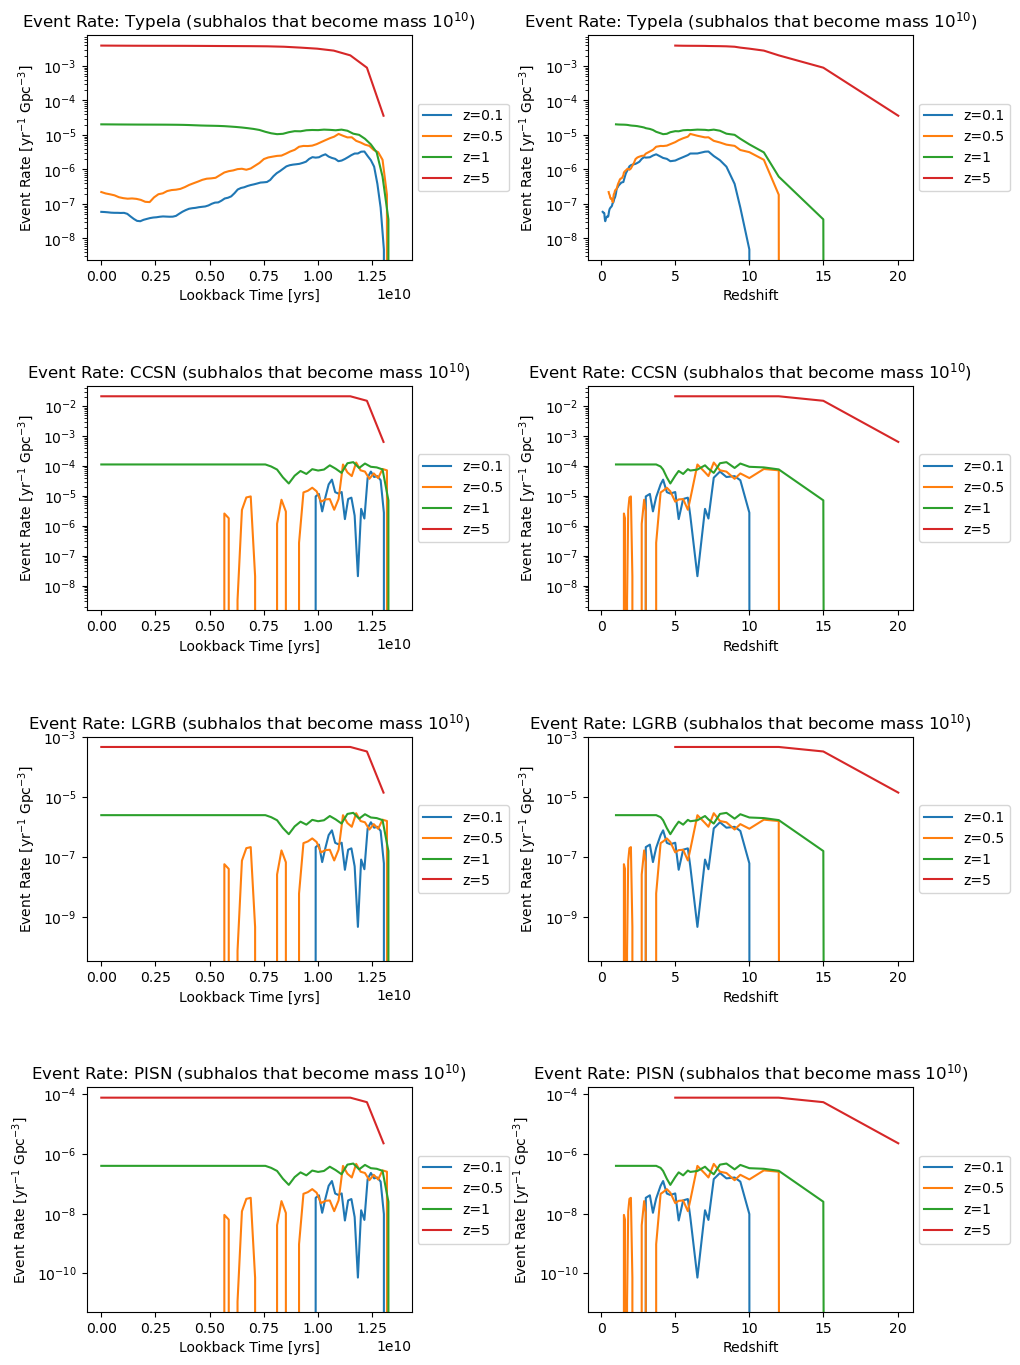

In [18]:
# comparing between redshifts for mass5

figure, axis = plt.subplots(4, 2, figsize=(11, 15))
figure.tight_layout(pad=7.0)

# typeIa
axis[0,0].plot(edges5_91, out5_91[:,0][0], label='z=0.1')
axis[0,0].plot(edges5_67, out5_67[:,0][0], label='z=0.5')
axis[0,0].plot(edges5_50, out5_50[:,0][0], label='z=1')
axis[0,0].plot(edges5_17, out5_17[:,0][0], label='z=5')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: TypeIa (subhalos that become mass 10$^{10}$)")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'][8:], out5_91[:,0][0], label='z=0.1')
axis[0,1].plot(SFH.attrs['redshift'][32:], out5_67[:,0][0], label='z=0.5')
axis[0,1].plot(SFH.attrs['redshift'][49:], out5_50[:,0][0], label='z=1')
axis[0,1].plot(SFH.attrs['redshift'][82:], out5_17[:,0][0], label='z=5')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: TypeIa (subhalos that become mass 10$^{10}$)")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# CCSN
axis[1,0].plot(edges5_91, out5_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,0].plot(edges5_67, out5_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,0].plot(edges5_50, out5_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,0].plot(edges5_17, out5_17[:,1:5][0].sum(axis=0), label='z=5')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: CCSN (subhalos that become mass 10$^{10}$)")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'][8:], out5_91[:,1:5][0].sum(axis=0), label='z=0.1')
axis[1,1].plot(SFH.attrs['redshift'][32:], out5_67[:,1:5][0].sum(axis=0), label='z=0.5')
axis[1,1].plot(SFH.attrs['redshift'][49:], out5_50[:,1:5][0].sum(axis=0), label='z=1')
axis[1,1].plot(SFH.attrs['redshift'][82:], out5_17[:,1:5][0].sum(axis=0), label='z=5')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: CCSN (subhalos that become mass 10$^{10}$)")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# LGRB
axis[2,0].plot(edges5_91, out5_91[:,5][0], label='z=0.1')
axis[2,0].plot(edges5_67, out5_67[:,5][0], label='z=0.5')
axis[2,0].plot(edges5_50, out5_50[:,5][0], label='z=1')
axis[2,0].plot(edges5_17, out5_17[:,5][0], label='z=5')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: LGRB (subhalos that become mass 10$^{10}$)")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'][8:], out5_91[:,5][0], label='z=0.1')
axis[2,1].plot(SFH.attrs['redshift'][32:], out5_67[:,5][0], label='z=0.5')
axis[2,1].plot(SFH.attrs['redshift'][49:], out5_50[:,5][0], label='z=1')
axis[2,1].plot(SFH.attrs['redshift'][82:], out5_17[:,5][0], label='z=5')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: LGRB (subhalos that become mass 10$^{10}$)")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# PISN
axis[3,0].plot(edges5_91, out5_91[:,6][0], label='z=0.1')
axis[3,0].plot(edges5_67, out5_67[:,6][0], label='z=0.5')
axis[3,0].plot(edges5_50, out5_50[:,6][0], label='z=1')
axis[3,0].plot(edges5_17, out5_17[:,6][0], label='z=5')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: PISN (subhalos that become mass 10$^{10}$)")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'][8:], out5_91[:,6][0], label='z=0.1')
axis[3,1].plot(SFH.attrs['redshift'][32:], out5_67[:,6][0], label='z=0.5')
axis[3,1].plot(SFH.attrs['redshift'][49:], out5_50[:,6][0], label='z=1')
axis[3,1].plot(SFH.attrs['redshift'][82:], out5_17[:,6][0], label='z=5')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: PISN (subhalos that become mass 10$^{10}$)")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

In [19]:
# Comparing transient event rates between masses

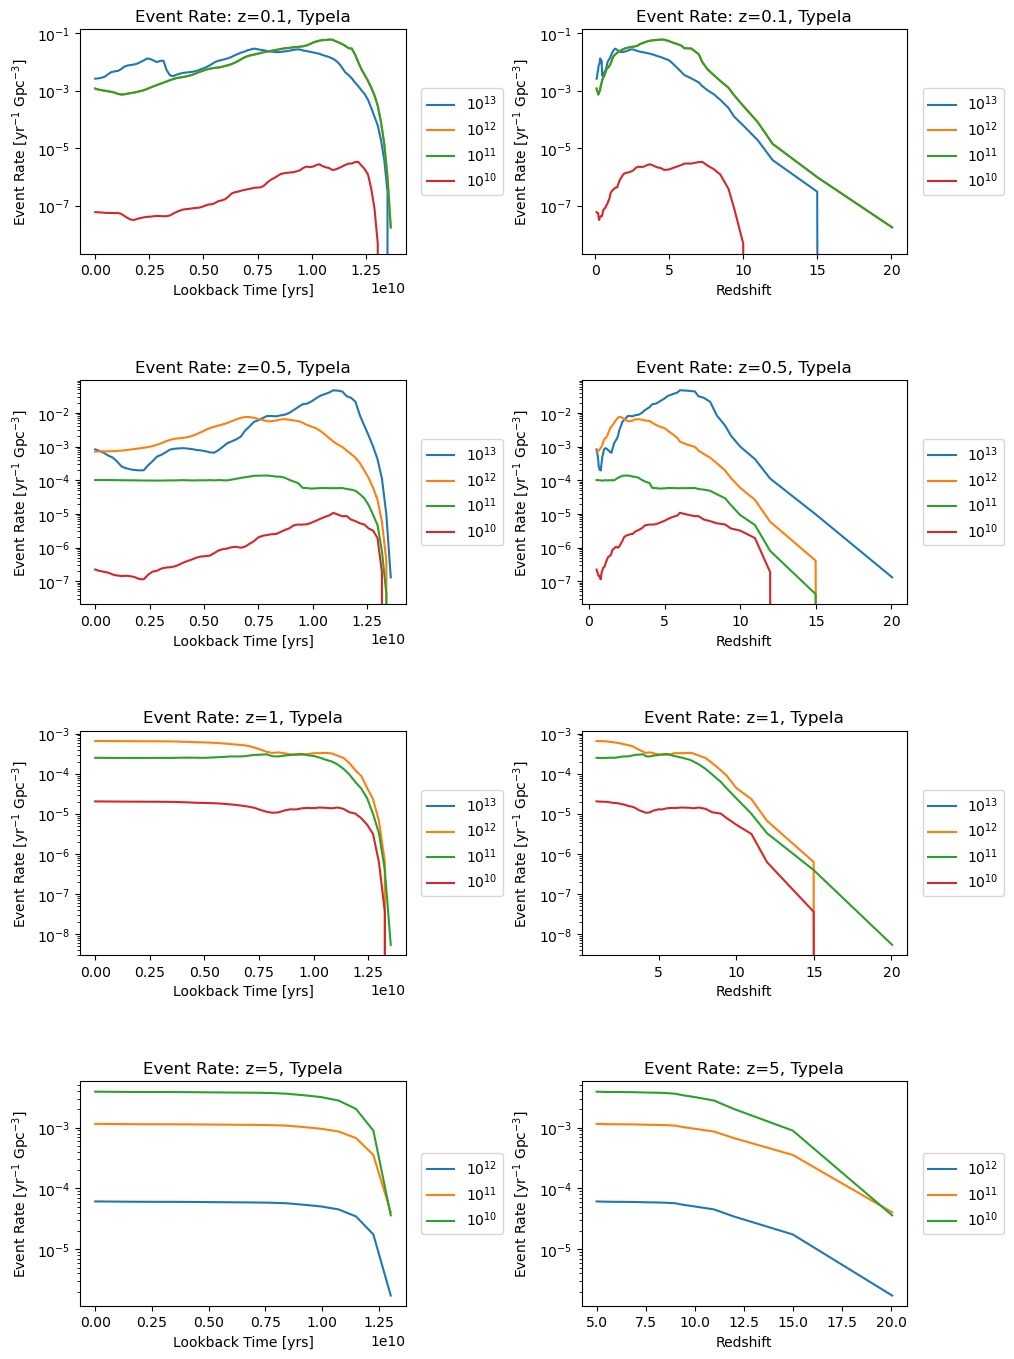

In [20]:
# typeIa

figure, axis = plt.subplots(4, 2, figsize=(11, 15))
figure.tight_layout(pad=7.0)

# z=0.1, snapshot=91
axis[0,0].plot(edges2_91, out2_91[:,0][0], label='10$^{13}$')
axis[0,0].plot(edges3_91, out3_91[:,0][0], label='10$^{12}$')
axis[0,0].plot(edges4_91, out4_91[:,0][0], label='10$^{11}$')
axis[0,0].plot(edges5_91, out5_91[:,0][0], label='10$^{10}$')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: z=0.1, TypeIa")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'][8:], out2_91[:,0][0], label='10$^{13}$')
axis[0,1].plot(SFH.attrs['redshift'][8:], out3_91[:,0][0], label='10$^{12}$')
axis[0,1].plot(SFH.attrs['redshift'][8:], out4_91[:,0][0], label='10$^{11}$')
axis[0,1].plot(SFH.attrs['redshift'][8:], out5_91[:,0][0], label='10$^{10}$')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: z=0.1, TypeIa")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.5, snapshot=67
axis[1,0].plot(edges2_67, out2_67[:,0][0], label='10$^{13}$')
axis[1,0].plot(edges3_67, out3_67[:,0][0], label='10$^{12}$')
axis[1,0].plot(edges4_67, out4_67[:,0][0], label='10$^{11}$')
axis[1,0].plot(edges5_67, out5_67[:,0][0], label='10$^{10}$')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: z=0.5, TypeIa")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'][32:], out2_67[:,0][0], label='10$^{13}$')
axis[1,1].plot(SFH.attrs['redshift'][32:], out3_67[:,0][0], label='10$^{12}$')
axis[1,1].plot(SFH.attrs['redshift'][32:], out4_67[:,0][0], label='10$^{11}$')
axis[1,1].plot(SFH.attrs['redshift'][32:], out5_67[:,0][0], label='10$^{10}$')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: z=0.5, TypeIa")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=1, snapshot=50
axis[2,0].plot(edges2_50, out2_50[:,0][0], label='10$^{13}$')
axis[2,0].plot(edges3_50, out3_50[:,0][0], label='10$^{12}$')
axis[2,0].plot(edges4_50, out4_50[:,0][0], label='10$^{11}$')
axis[2,0].plot(edges5_50, out5_50[:,0][0], label='10$^{10}$')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: z=1, TypeIa")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'][49:], out2_50[:,0][0], label='10$^{13}$')
axis[2,1].plot(SFH.attrs['redshift'][49:], out3_50[:,0][0], label='10$^{12}$')
axis[2,1].plot(SFH.attrs['redshift'][49:], out4_50[:,0][0], label='10$^{11}$')
axis[2,1].plot(SFH.attrs['redshift'][49:], out5_50[:,0][0], label='10$^{10}$')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: z=1, TypeIa")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=5, snapshot=17
axis[3,0].plot(edges3_17, out3_17[:,0][0], label='10$^{12}$')
axis[3,0].plot(edges4_17, out4_17[:,0][0], label='10$^{11}$')
axis[3,0].plot(edges5_17, out5_17[:,0][0], label='10$^{10}$')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: z=5, TypeIa")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'][82:], out3_17[:,0][0], label='10$^{12}$')
axis[3,1].plot(SFH.attrs['redshift'][82:], out4_17[:,0][0], label='10$^{11}$')
axis[3,1].plot(SFH.attrs['redshift'][82:], out5_17[:,0][0], label='10$^{10}$')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: z=5, TypeIa")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

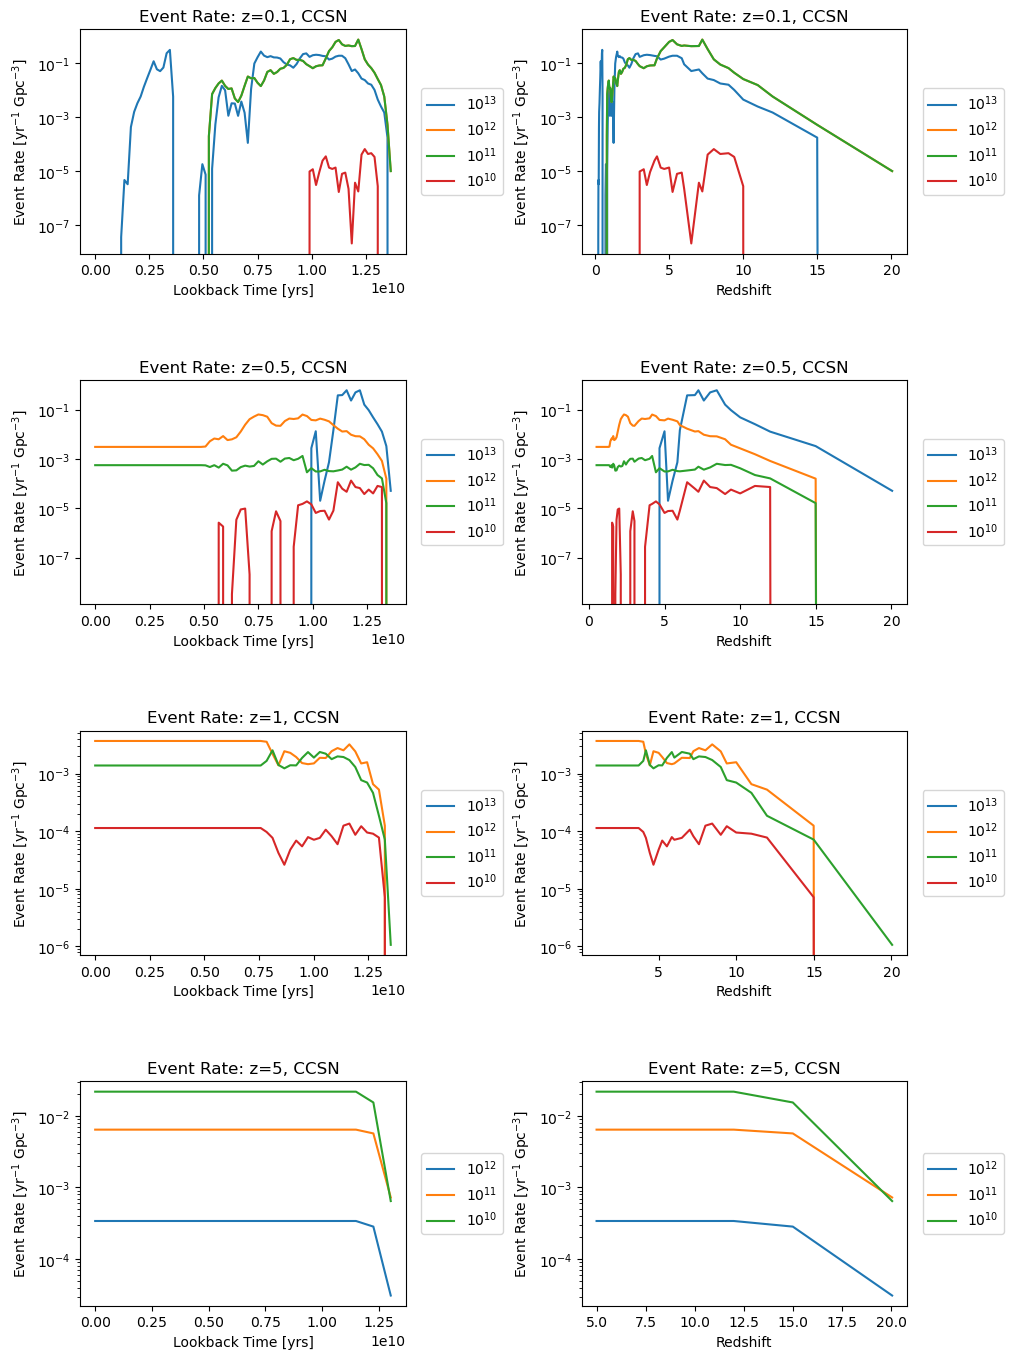

In [21]:
# CCSN

figure, axis = plt.subplots(4, 2, figsize=(11, 15))
figure.tight_layout(pad=7.0)

# z=0.1, snapshot=91
axis[0,0].plot(edges2_91, out2_91[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[0,0].plot(edges3_91, out3_91[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[0,0].plot(edges4_91, out4_91[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[0,0].plot(edges5_91, out5_91[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: z=0.1, CCSN")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'][8:], out2_91[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[0,1].plot(SFH.attrs['redshift'][8:], out3_91[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[0,1].plot(SFH.attrs['redshift'][8:], out4_91[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[0,1].plot(SFH.attrs['redshift'][8:], out5_91[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: z=0.1, CCSN")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.5, snapshot=67
axis[1,0].plot(edges2_67, out2_67[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[1,0].plot(edges3_67, out3_67[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[1,0].plot(edges4_67, out4_67[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[1,0].plot(edges5_67, out5_67[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: z=0.5, CCSN")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'][32:], out2_67[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[1,1].plot(SFH.attrs['redshift'][32:], out3_67[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[1,1].plot(SFH.attrs['redshift'][32:], out4_67[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[1,1].plot(SFH.attrs['redshift'][32:], out5_67[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: z=0.5, CCSN")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=1, snapshot=50
axis[2,0].plot(edges2_50, out2_50[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[2,0].plot(edges3_50, out3_50[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[2,0].plot(edges4_50, out4_50[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[2,0].plot(edges5_50, out5_50[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: z=1, CCSN")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'][49:], out2_50[:,1:5][0].sum(axis=0), label='10$^{13}$')
axis[2,1].plot(SFH.attrs['redshift'][49:], out3_50[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[2,1].plot(SFH.attrs['redshift'][49:], out4_50[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[2,1].plot(SFH.attrs['redshift'][49:], out5_50[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: z=1, CCSN")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=5, snapshot=17
axis[3,0].plot(edges3_17, out3_17[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[3,0].plot(edges4_17, out4_17[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[3,0].plot(edges5_17, out5_17[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: z=5, CCSN")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'][82:], out3_17[:,1:5][0].sum(axis=0), label='10$^{12}$')
axis[3,1].plot(SFH.attrs['redshift'][82:], out4_17[:,1:5][0].sum(axis=0), label='10$^{11}$')
axis[3,1].plot(SFH.attrs['redshift'][82:], out5_17[:,1:5][0].sum(axis=0), label='10$^{10}$')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: z=5, CCSN")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

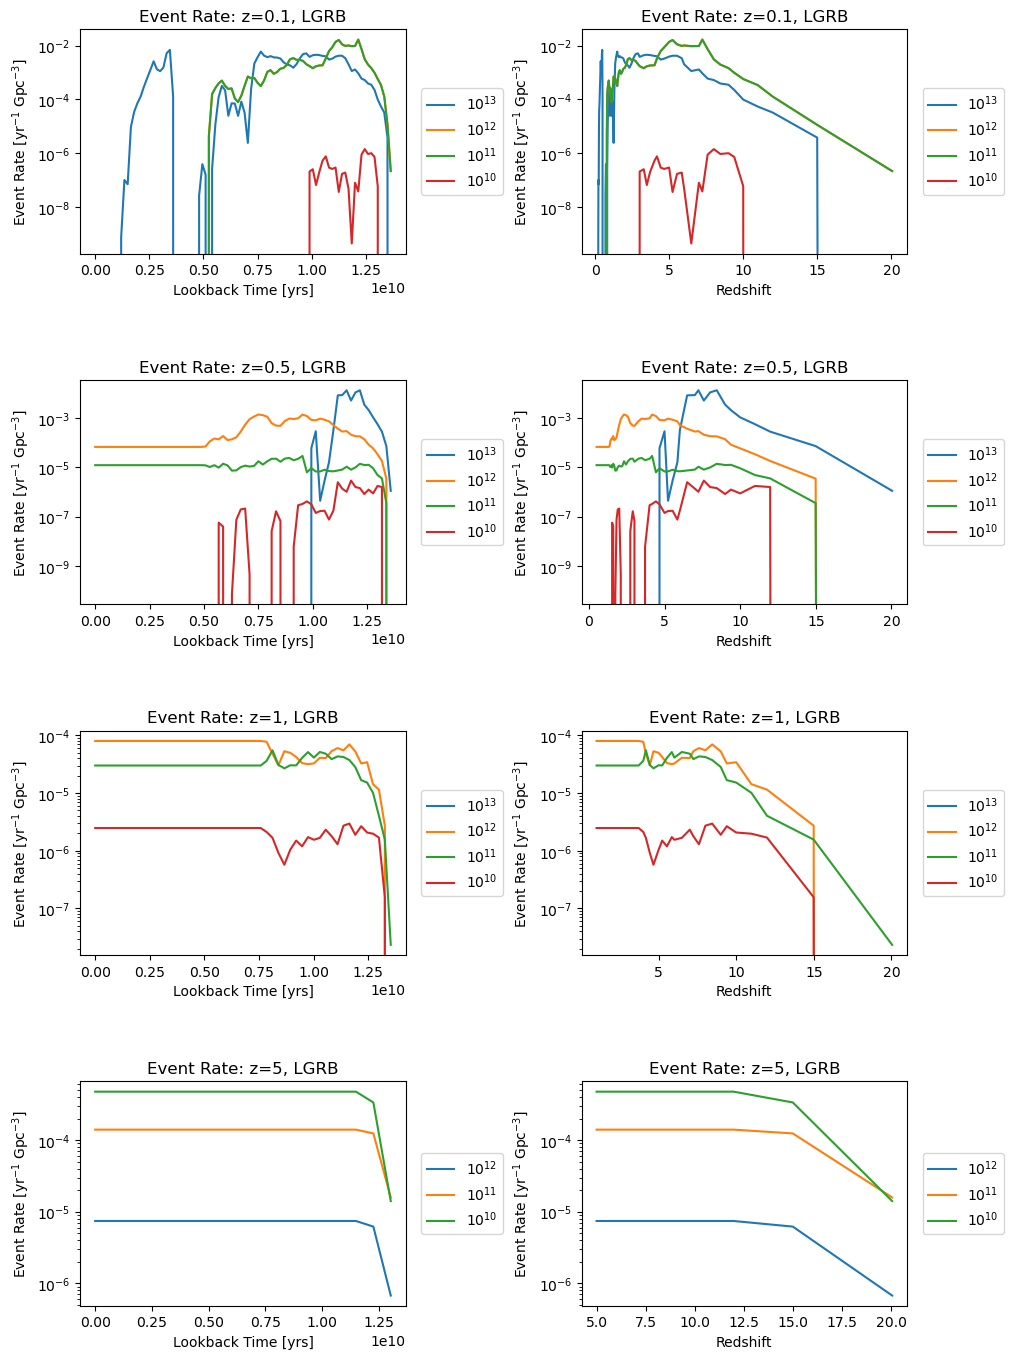

In [22]:
# LGRB

figure, axis = plt.subplots(4, 2, figsize=(11, 15))
figure.tight_layout(pad=7.0)

# z=0.1, snapshot=91
axis[0,0].plot(edges2_91, out2_91[:,5][0], label='10$^{13}$')
axis[0,0].plot(edges3_91, out3_91[:,5][0], label='10$^{12}$')
axis[0,0].plot(edges4_91, out4_91[:,5][0], label='10$^{11}$')
axis[0,0].plot(edges5_91, out5_91[:,5][0], label='10$^{10}$')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: z=0.1, LGRB")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'][8:], out2_91[:,5][0], label='10$^{13}$')
axis[0,1].plot(SFH.attrs['redshift'][8:], out3_91[:,5][0], label='10$^{12}$')
axis[0,1].plot(SFH.attrs['redshift'][8:], out4_91[:,5][0], label='10$^{11}$')
axis[0,1].plot(SFH.attrs['redshift'][8:], out5_91[:,5][0], label='10$^{10}$')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: z=0.1, LGRB")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.5, snapshot=67
axis[1,0].plot(edges2_67, out2_67[:,5][0], label='10$^{13}$')
axis[1,0].plot(edges3_67, out3_67[:,5][0], label='10$^{12}$')
axis[1,0].plot(edges4_67, out4_67[:,5][0], label='10$^{11}$')
axis[1,0].plot(edges5_67, out5_67[:,5][0], label='10$^{10}$')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: z=0.5, LGRB")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'][32:], out2_67[:,5][0], label='10$^{13}$')
axis[1,1].plot(SFH.attrs['redshift'][32:], out3_67[:,5][0], label='10$^{12}$')
axis[1,1].plot(SFH.attrs['redshift'][32:], out4_67[:,5][0], label='10$^{11}$')
axis[1,1].plot(SFH.attrs['redshift'][32:], out5_67[:,5][0], label='10$^{10}$')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: z=0.5, LGRB")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=1, snapshot=50
axis[2,0].plot(edges2_50, out2_50[:,5][0], label='10$^{13}$')
axis[2,0].plot(edges3_50, out3_50[:,5][0], label='10$^{12}$')
axis[2,0].plot(edges4_50, out4_50[:,5][0], label='10$^{11}$')
axis[2,0].plot(edges5_50, out5_50[:,5][0], label='10$^{10}$')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: z=1, LGRB")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'][49:], out2_50[:,5][0], label='10$^{13}$')
axis[2,1].plot(SFH.attrs['redshift'][49:], out3_50[:,5][0], label='10$^{12}$')
axis[2,1].plot(SFH.attrs['redshift'][49:], out4_50[:,5][0], label='10$^{11}$')
axis[2,1].plot(SFH.attrs['redshift'][49:], out5_50[:,5][0], label='10$^{10}$')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: z=1, LGRB")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=5, snapshot=17
axis[3,0].plot(edges3_17, out3_17[:,5][0], label='10$^{12}$')
axis[3,0].plot(edges4_17, out4_17[:,5][0], label='10$^{11}$')
axis[3,0].plot(edges5_17, out5_17[:,5][0], label='10$^{10}$')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: z=5, LGRB")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'][82:], out3_17[:,5][0], label='10$^{12}$')
axis[3,1].plot(SFH.attrs['redshift'][82:], out4_17[:,5][0], label='10$^{11}$')
axis[3,1].plot(SFH.attrs['redshift'][82:], out5_17[:,5][0], label='10$^{10}$')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: z=5, LGRB")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

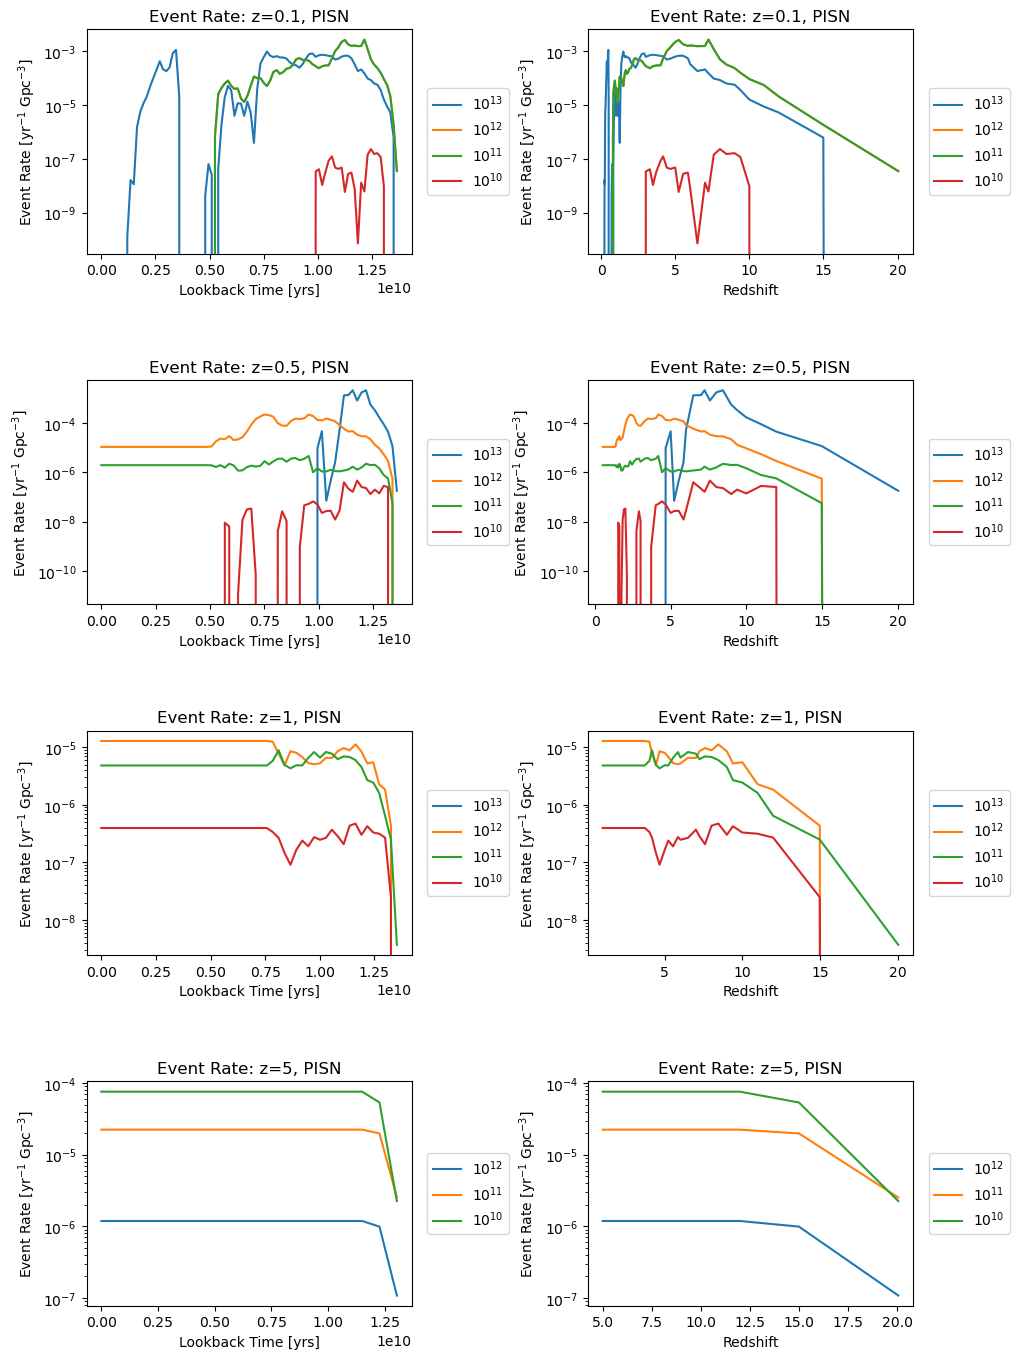

In [23]:
# PISN

figure, axis = plt.subplots(4, 2, figsize=(11, 15))
figure.tight_layout(pad=7.0)

# z=0.1, snapshot=91
axis[0,0].plot(edges2_91, out2_91[:,6][0], label='10$^{13}$')
axis[0,0].plot(edges3_91, out3_91[:,6][0], label='10$^{12}$')
axis[0,0].plot(edges4_91, out4_91[:,6][0], label='10$^{11}$')
axis[0,0].plot(edges5_91, out5_91[:,6][0], label='10$^{10}$')
axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Lookback Time [yrs]')
axis[0,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,0].set_title(r"Event Rate: z=0.1, PISN")
pos = axis[0,0].get_position()
axis[0,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[0,1].plot(SFH.attrs['redshift'][8:], out2_91[:,6][0], label='10$^{13}$')
axis[0,1].plot(SFH.attrs['redshift'][8:], out3_91[:,6][0], label='10$^{12}$')
axis[0,1].plot(SFH.attrs['redshift'][8:], out4_91[:,6][0], label='10$^{11}$')
axis[0,1].plot(SFH.attrs['redshift'][8:], out5_91[:,6][0], label='10$^{10}$')
axis[0,1].set_yscale('log')
axis[0,1].set_xlabel('Redshift')
axis[0,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[0,1].set_title(r"Event Rate: z=0.1, PISN")
pos = axis[0,1].get_position()
axis[0,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[0,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=0.5, snapshot=67
axis[1,0].plot(edges2_67, out2_67[:,6][0], label='10$^{13}$')
axis[1,0].plot(edges3_67, out3_67[:,6][0], label='10$^{12}$')
axis[1,0].plot(edges4_67, out4_67[:,6][0], label='10$^{11}$')
axis[1,0].plot(edges5_67, out5_67[:,6][0], label='10$^{10}$')
axis[1,0].set_yscale('log')
axis[1,0].set_xlabel('Lookback Time [yrs]')
axis[1,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,0].set_title(r"Event Rate: z=0.5, PISN")
pos = axis[1,0].get_position()
axis[1,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[1,1].plot(SFH.attrs['redshift'][32:], out2_67[:,6][0], label='10$^{13}$')
axis[1,1].plot(SFH.attrs['redshift'][32:], out3_67[:,6][0], label='10$^{12}$')
axis[1,1].plot(SFH.attrs['redshift'][32:], out4_67[:,6][0], label='10$^{11}$')
axis[1,1].plot(SFH.attrs['redshift'][32:], out5_67[:,6][0], label='10$^{10}$')
axis[1,1].set_yscale('log')
axis[1,1].set_xlabel('Redshift')
axis[1,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[1,1].set_title(r"Event Rate: z=0.5, PISN")
pos = axis[1,1].get_position()
axis[1,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[1,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=1, snapshot=50
axis[2,0].plot(edges2_50, out2_50[:,6][0], label='10$^{13}$')
axis[2,0].plot(edges3_50, out3_50[:,6][0], label='10$^{12}$')
axis[2,0].plot(edges4_50, out4_50[:,6][0], label='10$^{11}$')
axis[2,0].plot(edges5_50, out5_50[:,6][0], label='10$^{10}$')
axis[2,0].set_yscale('log')
axis[2,0].set_xlabel('Lookback Time [yrs]')
axis[2,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,0].set_title(r"Event Rate: z=1, PISN")
pos = axis[2,0].get_position()
axis[2,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[2,1].plot(SFH.attrs['redshift'][49:], out2_50[:,6][0], label='10$^{13}$')
axis[2,1].plot(SFH.attrs['redshift'][49:], out3_50[:,6][0], label='10$^{12}$')
axis[2,1].plot(SFH.attrs['redshift'][49:], out4_50[:,6][0], label='10$^{11}$')
axis[2,1].plot(SFH.attrs['redshift'][49:], out5_50[:,6][0], label='10$^{10}$')
axis[2,1].set_yscale('log')
axis[2,1].set_xlabel('Redshift')
axis[2,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[2,1].set_title(r"Event Rate: z=1, PISN")
pos = axis[2,1].get_position()
axis[2,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[2,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

# z=5, snapshot=17
axis[3,0].plot(edges3_17, out3_17[:,6][0], label='10$^{12}$')
axis[3,0].plot(edges4_17, out4_17[:,6][0], label='10$^{11}$')
axis[3,0].plot(edges5_17, out5_17[:,6][0], label='10$^{10}$')
axis[3,0].set_yscale('log')
axis[3,0].set_xlabel('Lookback Time [yrs]')
axis[3,0].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,0].set_title(r"Event Rate: z=5, PISN")
pos = axis[3,0].get_position()
axis[3,0].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,0].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))

axis[3,1].plot(SFH.attrs['redshift'][82:], out3_17[:,6][0], label='10$^{12}$')
axis[3,1].plot(SFH.attrs['redshift'][82:], out4_17[:,6][0], label='10$^{11}$')
axis[3,1].plot(SFH.attrs['redshift'][82:], out5_17[:,6][0], label='10$^{10}$')
axis[3,1].set_yscale('log')
axis[3,1].set_xlabel('Redshift')
axis[3,1].set_ylabel(r"Event Rate [yr$^{-1}$ Gpc$^{-3}$]")
axis[3,1].set_title(r"Event Rate: z=5, PISN")
pos = axis[3,1].get_position()
axis[3,1].set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
axis[3,1].legend(loc='center right', bbox_to_anchor=(1.32, 0.5))